<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
import sys
import os

from tqdm.notebook import tqdm as tqdm
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import cv2

import IPython
import ipywidgets

import time
import numpy as np

DATA_PATH = os.path.abspath('data')
IMAGE_PATH = os.path.join(DATA_PATH, 'train2017')
DATA_PATH

'C:\\pscripts\\nlp\\image_captioning\\data'

In [2]:
import requests
import random

def download_file(url, path):
    r = requests.get(url, allow_redirects=True)
    with open(path, 'wb') as f:
        f.write(r.content)
        
def make_learnable(model, learnable):
    for param in model.parameters():
        param.requires_grad = learnable
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    
def tensor_im_show(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Получим расширенные анотации, чтобы в будущем сопоставить с картинками

In [3]:
%%time
import zipfile
if not os.path.exists(os.path.join(DATA_PATH, 'annotations.zip')):
    download_file('http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                  os.path.join(DATA_PATH, 'annotations.zip'))

if not os.path.exists(os.path.join(DATA_PATH, 'annotations/captions_train2017.json')):
    with zipfile.ZipFile(os.path.join(DATA_PATH, 'annotations.zip'), 'r') as zip_ref:
        zip_ref.extract('annotations/captions_train2017.json', path=DATA_PATH)
        
annotations_data = json.load(open(os.path.join(DATA_PATH, 'annotations/captions_train2017.json')))

annotations_data.keys()

Wall time: 678 ms


dict_keys(['info', 'licenses', 'images', 'annotations'])

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Misha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Загрузим аннотации, сопоставим их по номеру в массиве с предзагруженными описаниями и эмбеддингами картинок

In [5]:
%%time

annotations = []
annot_captions = {}

tokenizer = nltk.WordPunctTokenizer()

# Загрузим все аннотации
for annot_data in annotations_data['annotations']:
    image_id = annot_data['image_id']
    if image_id not in annot_captions:
        annot_captions[image_id] = []
    if len(annot_captions[image_id]) > 4:
        continue
        
    # Хак для идеального сопоставления
    text = ' '.join(tokenizer.tokenize(annot_data['caption'].lower())).replace('....', '...')    
    
    annot_captions[image_id].append(text)

# Составим масссив из анатаций, вычислим аналогичные "id", запишем в поле "order" нужный индекс
for image in annotations_data['images']:
    image_id = image['id']
    annotation = {
        'file_name': image['file_name'],
        'url': image['coco_url'],
        'captions': annot_captions[image_id],
        'id': image_id
    }

    annotations.append(annotation)

del annot_captions

annotations[0]

Wall time: 2.53 s


{'file_name': '000000391895.jpg',
 'url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'captions': ['a man with a red helmet on a small moped on a dirt road .',
  'man riding a motor bike on a dirt road on the countryside .',
  'a man riding on the back of a motorcycle .',
  'a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud - wreathed mountains .',
  'a man in a red shirt and a red hat is on a motorcycle on a hill side .'],
 'id': 391895}

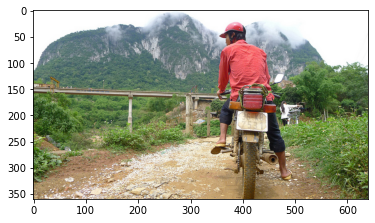

In [6]:
# Image example
plt.imshow(plt.imread(os.path.join(IMAGE_PATH, annotations[0]['file_name'])))

In [7]:
# Caption example
print('\n'.join(annotations[0]['captions']))

a man with a red helmet on a small moped on a dirt road .
man riding a motor bike on a dirt road on the countryside .
a man riding on the back of a motorcycle .
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud - wreathed mountains .
a man in a red shirt and a red hat is on a motorcycle on a hill side .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [8]:
import torch
import torchtext

# Эмбеддинги картинок
class TensorField(torchtext.data.RawField):
    def __init__(self, preprocessing=None, postprocessing=None, is_target=False):
        super(TensorField, self).__init__(preprocessing=preprocessing, postprocessing=postprocessing, is_target=is_target)
        
    def process(self, batch, device=None):
        batch = torch.stack(batch)
        if device:
            batch = batch.to(device)
        return batch

In [9]:
from torchvision import transforms
import PIL

class ImageField(TensorField):
    def __init__(self, need_augmentation=False, preprocessing=None, postprocessing=None, is_target=False):
        super(TensorField, self).__init__(preprocessing=preprocessing, postprocessing=postprocessing, is_target=is_target)
        self.augment = need_augmentation
        self.aug_trans = transforms.Compose([
            transforms.RandomResizedCrop((299, 299), scale=(0.4, 1.5), ratio=(0.6, 1.5)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
        self.trans = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.CenterCrop((299, 299)),
            transforms.ToTensor()
        ])
    
    def load_image2tensor(self, path):
        image = PIL.Image.open(path)
        if image.mode != 'RGB':
            image = image.convert(mode='RGB')
        if self.augment:
            return self.aug_trans(image)
        return self.trans(image)
        
    def process(self, batch, device=None):
        batch = list(map(self.load_image2tensor, batch))
        return super().process(batch, device)
    
    def set_need_augmentation(self, augment=True):
        self.augment = augment
    
SRC = ImageField(
    is_target=False)

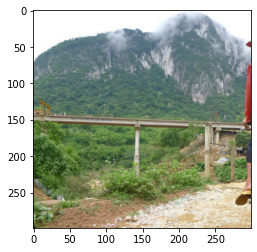

In [10]:
# Augmented image
SRC.set_need_augmentation(True)
tensor_im_show(SRC.process([SRC.preprocess(os.path.join(IMAGE_PATH, annotations[0]['file_name']))])[0])

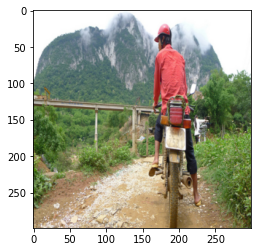

In [11]:
# Normal image
SRC.set_need_augmentation(False)
tensor_im_show(SRC.process([SRC.preprocess(os.path.join(IMAGE_PATH, annotations[0]['file_name']))])[0])

In [12]:
import random

# Field, который принимает на вход массив строк и выводит результат в двух режимах:
# * random - режим выбора случайной строки из массива (для обучения)
# * const - режим выбора строки номер n_epoch % n_cases (например для инференса или последовательного обхода)
class RandomField(torchtext.data.Field):
    def __init__(self, mode='random', epoch=0, sequential=True, use_vocab=True, init_token=None,
                 eos_token=None, fix_length=None, dtype=torch.long,
                 preprocessing=None, postprocessing=None, lower=False,
                 tokenize=None, tokenizer_language='en', include_lengths=False,
                 batch_first=False, pad_token="<pad>", unk_token="<unk>",
                 pad_first=False, truncate_first=False, stop_words=None,
                 is_target=False):
        super(RandomField, self).__init__(sequential=sequential, use_vocab=use_vocab, init_token=init_token,
                 eos_token=eos_token, fix_length=fix_length, dtype=dtype,
                 preprocessing=preprocessing, postprocessing=postprocessing, lower=lower,
                 tokenize=tokenize, tokenizer_language=tokenizer_language, include_lengths=include_lengths,
                 batch_first=batch_first, pad_token=pad_token, unk_token=unk_token,
                 pad_first=pad_first, truncate_first=truncate_first, stop_words=stop_words,
                 is_target=is_target)
        
        self.sep = 0
        self.epoch = epoch
        self.set_mode(mode)
        
    def set_mode(self, mode):
        assert mode in ['const', 'random'], 'Mode must be in the range'
        self.random = mode == 'random'

    def set_random_mode(self):
        self.random = True
    def set_const_mode(self):
        self.random = False
    def set_epoch(self, epoch):
        self.epoch = epoch
        
    def preprocess(self, x):
        if type(x) is str:
            return super().preprocess(x)
            x = ' <sep> '.join(x)
        return RandomField.list_join(['<sep>'], map(super().preprocess, x))
    def process(self, batch, device=None):
        
        for i in range(len(batch)):
            ids = [0] + [idx + 1 for idx, x in enumerate(batch[i]) if x == '<sep>'] + [len(batch[i]) + 1]
            r = random.randint(0, len(ids) - 2) if self.random else self.epoch % (len(ids) - 1)
            batch[i] = batch[i][ids[r]:ids[r + 1]-1]
            
        return super().process(batch, device)
    
    def build_vocab(self, *args, **kwargs):
        super().build_vocab(specials=kwargs.pop('specials', []) + ['<sep>'], *args, **kwargs)
        self.sep = self.vocab.stoi['<sep>']
        
    def list_join(sep, list_of_lists):
        l = []
        for it in list_of_lists:
            if l: l.extend(sep)
            l.extend(it)
        return l
        
TRG = RandomField(
    tokenize=tokenizer.tokenize,
    init_token = '<sos>', 
    eos_token = '<eos>',
    is_target=True,
    lower = True,
    batch_first = True)

In [13]:
fields = [('src', SRC), ('trg', TRG)]

# Я взял annotations для лучшего согласования токенайзера, который я использую, + мета информация
def make_data_examples(annotations=annotations, fields=fields):
    data = [
        torchtext.data.Example.fromlist([os.path.join(IMAGE_PATH, a['file_name']), a['captions']], fields)
        for a in annotations
    ]
    return data

dataset = torchtext.data.Dataset(
    examples=make_data_examples(annotations=annotations, fields=fields),
    fields=fields
)

en_prebuild_vectors = torchtext.vocab.FastText(language='en')
TRG.build_vocab(dataset, min_freq=1, vectors=en_prebuild_vectors, specials=['<cls>', '<mask>'])
del(en_prebuild_vectors)

print(f'Размер словаря: {len(TRG.vocab)}')
print('Первые метки в словаре:', ', '.join(TRG.vocab.itos[:10]))

Размер словаря: 26938
Первые метки в словаре: <unk>, <pad>, <sos>, <eos>, <cls>, <mask>, <sep>, a, ., on


Протестируем random режим: все индексы должны быть одинковыми, а второй столбец (второе слово) должен "гулять"

In [14]:
set_seed()
TRG.set_random_mode()
TRG.process([TRG.preprocess(["a man, who", "the man, who"])] * 10)

tensor([[  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,  11,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,  11,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3]])

Протестируем константный режим: все индексы должны быть одинковыми, а второй столбец (второе слово) должен иметь одно значение для первых пяти элементов и другое значени для остальных

In [15]:
TRG.set_const_mode()
TRG.set_epoch(1)
batch = [TRG.process([TRG.preprocess(["a man, who", "the man, who"])] * 5)]
TRG.set_epoch(0)
batch += [TRG.process([TRG.preprocess(["a man, who", "the man, who"])] * 5)]
batch = torch.cat(batch, dim=0)
batch

tensor([[  2,  11,  16,  21, 322,   3],
        [  2,  11,  16,  21, 322,   3],
        [  2,  11,  16,  21, 322,   3],
        [  2,  11,  16,  21, 322,   3],
        [  2,  11,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3],
        [  2,   7,  16,  21, 322,   3]])

Теперь поделим на выборки и создадим итераторы

In [16]:
set_seed()
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.getstate())

In [17]:
def _len_sort_key(x):
    return len(x.src)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is', device)

BATCH_SIZE = 150

train_iterator, valid_iterator, test_iterator = torchtext.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

Device is cuda


### 2. Напишем свой трансформер для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [18]:
import torch, torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from beheaded_inception3 import beheaded_inception_v3

Создадим сеть с трансформер

In [19]:
class CaptionNet(nn.Module):
    def clones(module, N):
        "Produce N identical layers."
        return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
    
    class LayerNorm(nn.Module):
        "Construct a layernorm module (See citation for details)."
        def __init__(self, features, eps=1e-6):
            super(CaptionNet.LayerNorm, self).__init__()
            self.a_2 = nn.Parameter(torch.ones(features))
            self.b_2 = nn.Parameter(torch.zeros(features))
            self.eps = eps
        def forward(self, x):
            mean = x.mean(-1, keepdim=True)
            std = x.std(-1, keepdim=True)
            return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
    class Generator2(nn.Module):
        "Define standard linear + softmax generation step."
        def __init__(self, d_model, vocab):
            super(CaptionNet.Generator2, self).__init__()
            self.proj = nn.Linear(d_model, vocab)
        def forward(self, x):
            return F.log_softmax(self.proj(x), dim=-1)
    class Generator(nn.Module):
        "Define standard linear + softmax generation step."
        def __init__(self, d_model, vocab):
            super(CaptionNet.Generator, self).__init__()
            self.proj = nn.Linear(d_model, vocab)
        def forward(self, x):
            return self.proj(x)
        
    class Encoder(nn.Module):
        "Core encoder is a stack of N layers"
        def __init__(self, layer, N):
            super(CaptionNet.Encoder, self).__init__()
            self.layers = CaptionNet.clones(layer, N)
            self.norm = CaptionNet.LayerNorm(layer.size)

        def forward(self, x, mask):
            "Pass the input (and mask) through each layer in turn."
            for layer in self.layers:
                x = layer(x, mask)
            return self.norm(x)
        
    class SublayerConnection(nn.Module):
        """
        A residual connection followed by a layer norm.
        Note for code simplicity the norm is first as opposed to last.
        """
        def __init__(self, size, dropout):
            super(CaptionNet.SublayerConnection, self).__init__()
            self.norm = CaptionNet.LayerNorm(size)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x, sublayer):
            "Apply residual connection to any sublayer with the same size."
            return x + self.dropout(sublayer(self.norm(x)))
        
    class EncoderLayer(nn.Module):
        "Encoder is made up of self-attn and feed forward (defined below)"
        def __init__(self, size, self_attn, feed_forward, dropout):
            super(CaptionNet.EncoderLayer, self).__init__()
            self.self_attn = self_attn
            self.feed_forward = feed_forward
            self.sublayer = CaptionNet.clones(CaptionNet.SublayerConnection(size, dropout), 2)
            self.size = size
        def forward(self, x, mask):
            "Follow Figure 1 (left) for connections."
            x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
            return self.sublayer[1](x, self.feed_forward)
        
    class Decoder(nn.Module):
        "Generic N layer decoder with masking."
        def __init__(self, layer, N):
            super(CaptionNet.Decoder, self).__init__()
            self.layers = CaptionNet.clones(layer, N)
            self.norm = CaptionNet.LayerNorm(layer.size)
        def forward(self, x, memory, src_mask, tgt_mask):
            for layer in self.layers:
                x = layer(x, memory, src_mask, tgt_mask)
            return self.norm(x)
        
    class DecoderLayer(nn.Module):
        "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
        def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
            super(CaptionNet.DecoderLayer, self).__init__()
            self.size = size
            self.self_attn = self_attn
            self.src_attn = src_attn
            self.feed_forward = feed_forward
            self.sublayer = CaptionNet.clones(CaptionNet.SublayerConnection(size, dropout), 3)
        def forward(self, x, memory, src_mask, tgt_mask):
            "Follow Figure 1 (right) for connections."
            m = memory
            x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
            x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
            return self.sublayer[2](x, self.feed_forward)
        
    def attention(query, key, value, mask=None, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim = -1)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn
    
    class MultiHeadedAttention(nn.Module):
        def __init__(self, h, d_model, dropout=0.1):
            "Take in model size and number of heads."
            super(CaptionNet.MultiHeadedAttention, self).__init__()
            assert d_model % h == 0
            # We assume d_v always equals d_k
            self.d_k = d_model // h
            self.h = h
            self.linears = CaptionNet.clones(nn.Linear(d_model, d_model), 4)
            self.attn = None
            self.dropout = nn.Dropout(p=dropout)

        def forward(self, query, key, value, mask=None):
            "Implements Figure 2"
            if mask is not None:
                # Same mask applied to all h heads.
                mask = mask.unsqueeze(1)
            nbatches = query.size(0)

            # 1) Do all the linear projections in batch from d_model => h x d_k 
            query, key, value = \
                [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                 for l, x in zip(self.linears, (query, key, value))]

            # 2) Apply attention on all the projected vectors in batch. 
            x, self.attn = CaptionNet.attention(query, key, value, mask=mask, 
                                     dropout=self.dropout)

            # 3) "Concat" using a view and apply a final linear. 
            x = x.transpose(1, 2).contiguous() \
                 .view(nbatches, -1, self.h * self.d_k)
            return self.linears[-1](x)
    
    class PositionwiseFeedForward(nn.Module):
        "Implements FFN equation."
        def __init__(self, d_model, d_ff, dropout=0.1):
            super(CaptionNet.PositionwiseFeedForward, self).__init__()
            self.w_1 = nn.Linear(d_model, d_ff)
            self.w_2 = nn.Linear(d_ff, d_model)
            self.dropout = nn.Dropout(dropout)
        def forward(self, x):
            return self.w_2(self.dropout(F.relu(self.w_1(x))))
        
    class PositionalEncoding(nn.Module):
        "Implement the PE function."
        def __init__(self, d_model, dropout, max_len=5000):
            super(CaptionNet.PositionalEncoding, self).__init__()
            self.dropout = nn.Dropout(p=dropout)

            # Compute the positional encodings once in log space.
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2) *
                                 -(math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)
        def forward(self, x):
            x = x + torch.autograd.Variable(self.pe[:, :x.size(1)], 
                             requires_grad=False)
            return self.dropout(x)
        
    class Embeddings(nn.Module):
        def __init__(self, d_model, vocab):
            super(CaptionNet.Embeddings, self).__init__()
            self.lut = nn.Embedding(vocab, d_model)
            self.d_model = d_model
        def forward(self, x):
            return self.lut(x) * math.sqrt(self.d_model)
        
    class ImageEmbeddings2dChannels(nn.Module):
        def __init__(self, im_channels, d_model):
            super(CaptionNet.ImageEmbeddings2dChannels, self).__init__()
            self.lut = nn.Linear(im_channels * 4, d_model)
            self.d_model = d_model
            self.load_cnn()
        def load_cnn(self):
            self.cnn = beheaded_inception_v3(True)
        def forward(self, x):
            vectors_8x8, vectors_neck, logits = self.cnn(x)
            x = vectors_8x8.contiguous().reshape(vectors_8x8.shape[0], vectors_8x8.shape[1] // 4, -1)
            x = self.lut(x)
            return x
        
    class ImageEmbeddings2dPixels(nn.Module):
        def __init__(self, im_channels, d_model):
            super(CaptionNet.ImageEmbeddings2dPixels, self).__init__()
            self.lut = nn.Linear(im_channels, d_model)
            self.d_model = d_model
            self.load_cnn()
        def load_cnn(self):
            self.cnn = beheaded_inception_v3(True)
        def forward(self, x):
            vectors_8x8, vectors_neck, logits = self.cnn(x)
            x = vectors_8x8.contiguous().reshape(vectors_8x8.shape[0], vectors_8x8.shape[1], -1).permute(0, 2, 1)
            x = self.lut(x)
            return x
        
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(CaptionNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    # d_model - размерность "хиддена" модели (default 512)
    # d_ff - максимальное количество слов (default 2048)
    def make_model(tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
        "Helper: Construct a model from hyperparameters."
        c = copy.deepcopy
        attn = CaptionNet.MultiHeadedAttention(h, d_model)
        #ff_enc = CaptionNet.PositionwiseFeedForward(d_model, 2048 // 4, dropout)
        ff_enc = CaptionNet.PositionwiseFeedForward(d_model, 8 * 8, dropout)
        ff = CaptionNet.PositionwiseFeedForward(d_model, d_ff, dropout)
        position = CaptionNet.PositionalEncoding(d_model, dropout)
        position2d = CaptionNet.PositionalEncoding(d_model, dropout)
        model = CaptionNet(
            #CaptionNet.Encoder(CaptionNet.EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            CaptionNet.Encoder(CaptionNet.EncoderLayer(d_model, c(attn), c(ff_enc), dropout), N),
            CaptionNet.Decoder(CaptionNet.DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
            #nn.Sequential(CaptionNet.Embeddings(d_model, src_vocab), c(position)),
            #nn.Sequential(CaptionNet.ImageEmbeddings2dChannels(8 * 8, d_model), c(position2d)),
            nn.Sequential(CaptionNet.ImageEmbeddings2dPixels(2048, d_model), c(position2d)),
            nn.Sequential(CaptionNet.Embeddings(d_model, tgt_vocab), c(position)),
            CaptionNet.Generator(d_model, tgt_vocab))

        # This was important from their code. 
        # Initialize parameters with Glorot / fan_avg.
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
        for p in model.src_embed[0].lut.parameters():
            #nn.init.uniform_(p, -0.08, 0.08)
            #if p.dim() > 1:
            #    nn.init.normal_(p, 0., 0.01)
            nn.init.normal_(p, 0., 0.01)
                
        model.src_embed[0].load_cnn()
        return model
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), tgt, src_mask, tgt_mask)
    def encode(self, src, src_mask=None):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, tgt, src_mask=None, tgt_mask=None):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
    def make_learnable(module, learnable):
        for param in module.parameters():
            param.requires_grad = learnable
    def freeze_cnn(self, freeze=True):
        CaptionNet.make_learnable(self.src_embed[0].cnn, not freeze)
    def freeze_trg_embeddings(self, freeze=True):
        CaptionNet.make_learnable(self.tgt_embed[0].lut, not freeze)
None

Генератор маски для таргета

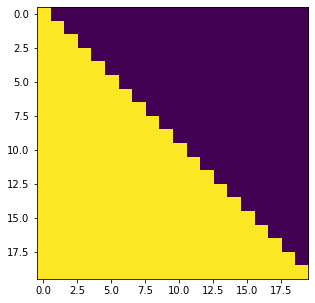

In [20]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

Класс для приведения филдов в удобный для трансформера вид

In [21]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad).to(trg.device)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

Лосс

In [22]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        x = F.log_softmax(x, dim=-1)
        
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist)

In [23]:
criterion = LabelSmoothing(size=len(TRG.vocab), padding_idx=TRG.vocab.stoi['<pad>'], smoothing=0.1)
criterion.to(device)

LabelSmoothing(
  (criterion): KLDivLoss()
)

In [24]:
#criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi['<pad>'], reduction='sum')

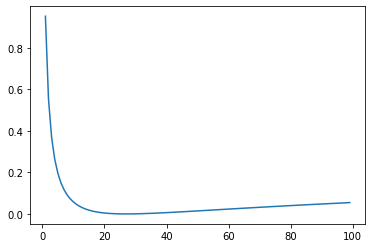

In [25]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(predict.log(),
                 torch.LongTensor([1])).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

Создаём сеть и инициализируем эмбеддинги векторами

In [26]:
network = CaptionNet.make_model(len(TRG.vocab), N=5, d_model=TRG.vocab.vectors.shape[1], d_ff=100, h=5, dropout=0.3)
with torch.no_grad():
    network.tgt_embed[0].lut.weight.copy_(TRG.vocab.vectors)
    network.generator.proj.weight.copy_(network.tgt_embed[0].lut.weight)
    #network.generator.proj.weight = network.tgt_embed[0].lut.weight

In [27]:
print(f'Количество параметров модели: {count_parameters(network)}')

Количество параметров модели: 49895722


In [28]:
# Переведём на ГПУ
network = network.to(device)

Планировщик напишу сам

In [29]:
class NoamScheduler:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamScheduler(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

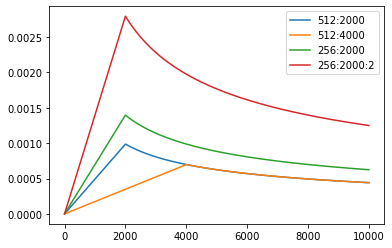

In [30]:
# Three settings of the lrate hyperparameters.
opts = [NoamScheduler(512, 1, 2000, None), 
        NoamScheduler(512, 1, 4000, None),
        NoamScheduler(256, 1, 2000, None),
        NoamScheduler(256, 2, 2000, None)]
plt.plot(np.arange(1, 10000), [[opt.rate(i) for opt in opts] for i in range(1, 10000)])
plt.legend(["512:2000", "512:4000", "256:2000", "256:2000:2"])
None

In [31]:
N_EPOCHS = 30
total_steps = N_EPOCHS * len(train_iterator)

optimizer = torch.optim.Adam(network.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamScheduler(network.src_embed[0].d_model, 1, 5 * len(train_iterator), optimizer)

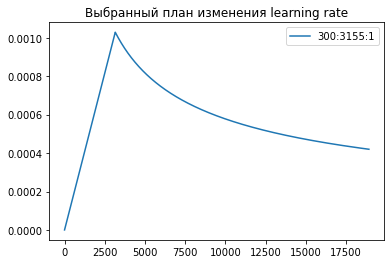

In [32]:
plt.title('Выбранный план изменения learning rate')
plt.plot(
    np.arange(1, total_steps),
    [scheduler.rate(i) for i in range(1, total_steps)],
    label=f'{scheduler.model_size}:{scheduler.warmup}:{scheduler.factor}')
plt.legend()
None

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [33]:
#torch.autograd.set_detect_anomaly(False)

In [34]:
def train(model, iterator, optimizer, criterion, clip, scheduler=None, loss_widget=None,
          train_history=None, valid_history=None, n_pad=0):
    model.train()
    
    epoch_loss = 0
    total_tokens = 0
    history = []
    
    bar = tqdm(enumerate(iterator), total=len(iterator))
    for i, batch in bar:
        
        batch = Batch(batch.src, batch.trg, n_pad)
        
        optimizer.zero_grad()
        
        out = model(batch.src, batch.trg, src_mask=None, tgt_mask=batch.trg_mask)
        out = model.generator(out)

        #output = [batch size, trg sent len, output dim]
        #trg_y = [batch size, trg sent len]
        loss = criterion(out.contiguous().reshape(-1, out.shape[-1]), batch.trg_y.contiguous().reshape(-1)) / batch.ntokens
        #print(loss.item())

        loss.backward()
        
        # Let's clip the gradient
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        if (scheduler is not None):
            scheduler.step()
        
        total_tokens += batch.ntokens.item()
        epoch_loss += loss.detach().item() * batch.ntokens.item()
        
        history.append(loss.detach().item())
        if (i + 1) % 10 == 0 and loss_widget is not None:
            with loss_widget:
                IPython.display.clear_output(wait=True)
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
                ax[0].plot(history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title('Current train loss')
                #ax[0].set_yscale('log')
                ax[1].set_title('Average losses')
                if train_history is not None:
                    ax[1].plot(train_history, label='general train history')
                    ax[1].set_xlabel('Epoch')
                if valid_history is not None:
                    ax[1].plot(valid_history, label='general valid history')
                plt.legend()
                plt.show()
        
    return epoch_loss / total_tokens

def evaluate(model, iterator, criterion, n_pad=0):
    
    model.eval()
    
    epoch_loss = 0
    total_tokens = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            batch = Batch(batch.src, batch.trg, n_pad)

            optimizer.zero_grad()

            out = model(batch.src, batch.trg, src_mask=None, tgt_mask=batch.trg_mask)
            out = model.generator(out)

            #output = [batch size, trg sent len, output dim]
            #trg_y = [batch size, trg sent len]
            loss = criterion(out.contiguous().reshape(-1, out.shape[-1]), batch.trg_y.contiguous().reshape(-1)) / batch.ntokens

            total_tokens += batch.ntokens.item()
            epoch_loss += loss.detach().item() * batch.ntokens.item()
        
    return epoch_loss / total_tokens

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
if os.path.exists('best-model-transformer.pt'):
    network.load_state_dict(torch.load('best-model-transformer.pt'))

Output()

  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 01 | Time: 14m 49s
	Train Loss: 1.975 | Train PPL:   7.205
	 Val. Loss: 1.846 |  Val. PPL:   6.332


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 02 | Time: 14m 44s
	Train Loss: 1.965 | Train PPL:   7.133
	 Val. Loss: 1.846 |  Val. PPL:   6.334


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 03 | Time: 22m 33s
	Train Loss: 1.972 | Train PPL:   7.182
	 Val. Loss: 1.859 |  Val. PPL:   6.415


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 04 | Time: 22m 31s
	Train Loss: 1.977 | Train PPL:   7.220
	 Val. Loss: 1.874 |  Val. PPL:   6.516


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 05 | Time: 22m 27s
	Train Loss: 1.993 | Train PPL:   7.336
	 Val. Loss: 1.878 |  Val. PPL:   6.542


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 06 | Time: 22m 34s
	Train Loss: 2.003 | Train PPL:   7.413
	 Val. Loss: 1.880 |  Val. PPL:   6.557


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 07 | Time: 22m 13s
	Train Loss: 1.994 | Train PPL:   7.345
	 Val. Loss: 1.877 |  Val. PPL:   6.533


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 08 | Time: 22m 22s
	Train Loss: 1.984 | Train PPL:   7.273
	 Val. Loss: 1.868 |  Val. PPL:   6.475


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 09 | Time: 22m 27s
	Train Loss: 1.978 | Train PPL:   7.230
	 Val. Loss: 1.863 |  Val. PPL:   6.441


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 10 | Time: 22m 37s
	Train Loss: 1.972 | Train PPL:   7.187
	 Val. Loss: 1.857 |  Val. PPL:   6.402


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 11 | Time: 22m 28s
	Train Loss: 1.965 | Train PPL:   7.136
	 Val. Loss: 1.853 |  Val. PPL:   6.378


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 12 | Time: 22m 29s
	Train Loss: 1.962 | Train PPL:   7.114
	 Val. Loss: 1.854 |  Val. PPL:   6.383


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 13 | Time: 22m 25s
	Train Loss: 1.952 | Train PPL:   7.040
	 Val. Loss: 1.856 |  Val. PPL:   6.400


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 14 | Time: 22m 27s
	Train Loss: 1.952 | Train PPL:   7.044
	 Val. Loss: 1.845 |  Val. PPL:   6.329


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 15 | Time: 22m 30s
	Train Loss: 1.943 | Train PPL:   6.980
	 Val. Loss: 1.842 |  Val. PPL:   6.310


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 16 | Time: 22m 30s
	Train Loss: 1.940 | Train PPL:   6.960
	 Val. Loss: 1.841 |  Val. PPL:   6.301


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 17 | Time: 22m 47s
	Train Loss: 1.935 | Train PPL:   6.925
	 Val. Loss: 1.840 |  Val. PPL:   6.299


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 18 | Time: 22m 38s
	Train Loss: 1.937 | Train PPL:   6.940
	 Val. Loss: 1.847 |  Val. PPL:   6.338


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 19 | Time: 22m 27s
	Train Loss: 1.932 | Train PPL:   6.905
	 Val. Loss: 1.840 |  Val. PPL:   6.295


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 20 | Time: 22m 29s
	Train Loss: 1.927 | Train PPL:   6.869
	 Val. Loss: 1.837 |  Val. PPL:   6.279


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 21 | Time: 22m 36s
	Train Loss: 1.925 | Train PPL:   6.854
	 Val. Loss: 1.836 |  Val. PPL:   6.270


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 22 | Time: 22m 46s
	Train Loss: 1.921 | Train PPL:   6.830
	 Val. Loss: 1.836 |  Val. PPL:   6.274


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 23 | Time: 22m 46s
	Train Loss: 1.918 | Train PPL:   6.806
	 Val. Loss: 1.837 |  Val. PPL:   6.275


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 24 | Time: 22m 40s
	Train Loss: 1.913 | Train PPL:   6.776
	 Val. Loss: 1.833 |  Val. PPL:   6.255


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 25 | Time: 22m 31s
	Train Loss: 1.916 | Train PPL:   6.791
	 Val. Loss: 1.834 |  Val. PPL:   6.258


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 26 | Time: 22m 36s
	Train Loss: 1.914 | Train PPL:   6.783
	 Val. Loss: 1.832 |  Val. PPL:   6.246


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 27 | Time: 22m 37s
	Train Loss: 1.909 | Train PPL:   6.748
	 Val. Loss: 1.833 |  Val. PPL:   6.256


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 28 | Time: 22m 30s
	Train Loss: 1.904 | Train PPL:   6.716
	 Val. Loss: 1.830 |  Val. PPL:   6.234


  0%|          | 0/631 [00:00<?, ?it/s]

Model saved
Epoch: 29 | Time: 22m 31s
	Train Loss: 1.906 | Train PPL:   6.729
	 Val. Loss: 1.828 |  Val. PPL:   6.219


  0%|          | 0/631 [00:00<?, ?it/s]

Epoch: 30 | Time: 22m 34s
	Train Loss: 1.905 | Train PPL:   6.719
	 Val. Loss: 1.828 |  Val. PPL:   6.222


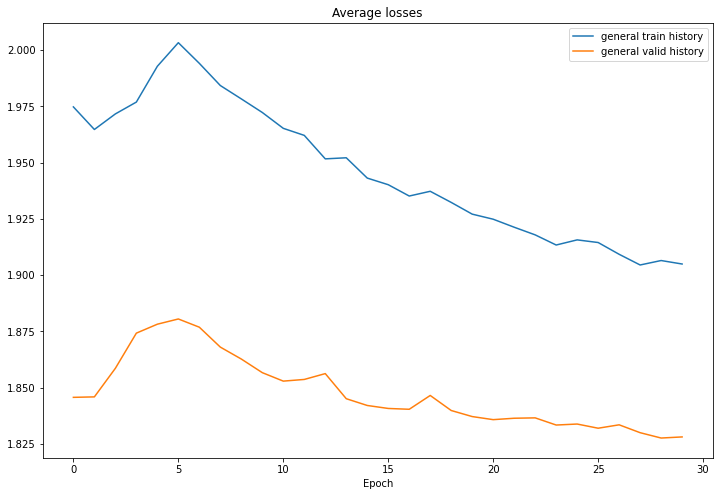

Best model loaded


In [36]:
train_history = []
valid_history = []

CLIP = 1.

best_valid_loss = float('inf')
best_model = None

random_capt = True # Random label or all labels step-by-step

# Fine tuning embeddings
#make_learnable(dec.embedding, False)

loss_widget = ipywidgets.Output()
IPython.display.display(loss_widget)

network.freeze_cnn(True)

for epoch in range(N_EPOCHS):
    
    torch.cuda.empty_cache()
    start_time = time.time()
    
    if epoch == 2:
        network.freeze_cnn(False)
    
    if random_capt:
        TRG.set_random_mode()
    else:
        TRG.set_const_mode()
        TRG.set_epoch(epoch)
    SRC.set_need_augmentation(True)
        
    train_loss = train(network, train_iterator, optimizer, criterion, CLIP, scheduler,
                       loss_widget, train_history, valid_history,
                      n_pad=TRG.vocab.stoi['<pad>'])
    
    TRG.set_const_mode()
    TRG.set_epoch(0)
    SRC.set_need_augmentation(False)
    
    valid_loss = evaluate(network, valid_iterator, criterion, n_pad=TRG.vocab.stoi['<pad>'])
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        st_d = network.state_dict()
        best_model = {k: st_d[k].cpu() for k in st_d}
        print('Model saved')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_history[-1]:.3f} | Train PPL: {np.exp(train_history[-1]):7.3f}')
    print(f'\t Val. Loss: {valid_history[-1]:.3f} |  Val. PPL: {np.exp(valid_history[-1]):7.3f}')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.set_title('Average losses')
if train_history is not None:
    ax.plot(train_history, label='general train history')
    ax.set_xlabel('Epoch')
if valid_history is not None:
    ax.plot(valid_history, label='general valid history')
plt.legend()
plt.show()

if best_model is not None:
    st_d = {k: best_model[k].to(device) for k in best_model}
    network.load_state_dict(st_d)
    print('Best model loaded')
    
torch.save(network.state_dict(), 'best-model-transformer.pt')
torch.save({'train_history': train_history, 'valid_history': valid_history}, 'info.pth')

In [37]:
#network.load_state_dict(torch.load('best-model-transformer.pt'))

## Inseption и получение результатов


In [38]:
def tensor2sentence(tesor):
    sentence = ''
    last_word = None
    for word in tesor:
        word = TRG.vocab.itos[word]
        if word == '<sos>' or word == '<pad>': continue
        elif word == '<eos>': break
        if last_word is None or last_word == '.':
            word = word.capitalize()
        if sentence and word != '.' and word != ',' and word != ':' and word != '?' and word != '!':
            sentence += ' '
        sentence += word
        last_word = word
    return sentence

def load_image2tensor(url):
    #sample image
    download_file(url, 'data/img.jpg')
    img = plt.imread('data/img.jpg')
    img = cv2.resize(src=img, dsize=(299, 299)).astype('float32') / 255.
    tensor = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32)
    return tensor

### Сгенерируем описание

In [39]:
def generate_caption(image, greedy=True, max_len=100):
    assert isinstance(image, torch.FloatTensor) and image.max() <= 1 \
        and image.max() >=0 and image.shape[0] == 3
    
    n_pad = TRG.vocab.stoi['<pad>']
    n_sos = TRG.vocab.stoi['<sos>']
    n_eos=TRG.vocab.stoi['<eos>']
    
    word = n_sos
    caption_prefix = torch.LongTensor([word])
    
    with torch.no_grad():
        memory = network.encode(image[None].to(device), None)

    # слово за словом генерируем описание картинки
    for _ in range(max_len):
        # 1. Представляем caption_prefix в виде матрицы
        # 2. Получить из трансформера логиты
        # 3. Перевести логиты трансформера в вероятности (например, с помощью F.softmax)
        # 4. Сэмплировать следующее слово в описании, используя полученные вероятности. Можно сэмплировать жадно 
        # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
        # 5. Добавляем новое слово в caption_prefix
        # 6. Если трансформер сгенерил символ конца предложения, останавливаемся
        
        with torch.no_grad():
            output = network.decode(memory, caption_prefix[None].to(device),
                src_mask=None, tgt_mask=subsequent_mask(caption_prefix.shape[0]).to(device))

            # Получим вероятности слов
            #output = torch.exp(network.generator(output[:, -1])).cpu()
            output = torch.softmax(network.generator(output[:, -1]), dim=-1).cpu()
            
            if greedy:
                word = output.argmax(dim=1).item()
            else:            
                # Получим вероятности + индексы лучших 10 слов
                values, indices = output.topk(10)

                # Установим минимальную вероятность в 2%
                values[indices == word] = 0 # Запретим повторение слов
                indices = indices[values > 0.02]
                values = values[values > 0.02]

                if values.shape[0] == 0:
                    # Нет слова с вероятностью > 10%, жадно берём "самое вероятное"
                    word = output.argmax(dim=1).item()
                else:
                    # Выбираем случайно слово из вероятных
                    word = indices[random.randint(0, indices.shape[0] - 1)].item()
            
        if word == n_pad:
            continue
            
        caption_prefix = torch.cat([caption_prefix, torch.LongTensor([word])], dim=0)
        
        if word == n_eos:
            break
            
    caption_prefix = tensor2sentence(caption_prefix)

    return caption_prefix

def generate_greedy_caption(image, max_len=100):
    return generate_caption(image, greedy=True, max_len=100)

def sample_possible_caption(image, max_len=100):
    return generate_caption(image, greedy=False, max_len=100)

### Скачаем пару картинок, чтобы проверить качество:

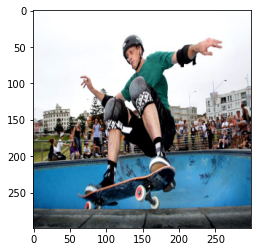

In [40]:
#sample image
img = load_image2tensor('https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg')
plt.imshow(img.permute(1, 2, 0).numpy())

In [41]:
print(f'Жадное описание: {generate_greedy_caption(img)}')
print()
print('Возможные описания из распределения:')
for i in range(10):
    print(f'{i+1}.', sample_possible_caption(img))

Жадное описание: A man riding a skateboard on a ramp.

Возможные описания из распределения:
1. A guy on a skateboard going up a ramp at the skate park.
2. The man is doing the skateboard flip outside
3. A young person skating in an arena during a skate game.
4. A skateboarder rides up the ledge while a crowd looks at him.
5. A boy riding his skateboard through a ramp in an obstacle course
6. A skateboarder performing a jump with other people watching.
7. The skateboarder in mid - jump at a skatepark
8. A skateboarder riding up the side of the pool at an event.
9. A guy on a skateboard going down a ramp at a skate park.
10. A boy jumping his skate board in the air


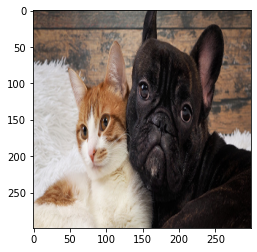

In [42]:
#sample image
img = load_image2tensor('http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg')
plt.imshow(img.permute(1, 2, 0).numpy())

In [43]:
print(f'Жадное описание: {generate_greedy_caption(img)}')
print()
print('Возможные описания из распределения:')
for i in range(10):
    print(f'{i+1}.', sample_possible_caption(img))

Жадное описание: A dog laying on a bed with a cat.

Возможные описания из распределения:
1. The two cats is sleeping in front of each other
2. Three cats laying together in their habitat.
3. Three dogs are resting together while laying next to a cat.
4. Three cats lying on top of a bed.
5. Two cats lay in the snow and resting their heads.
6. Two large adorable brown dogs lying together on the bed.
7. Three cats resting on the couch in a room
8. Two cats that have fallen down on their heads
9. The two large black cats are laying down with a cat
10. The cat is curled up and laying next to two black dog ' s on a bed


# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

In [44]:
# apply your network on images you've found
def show_image_by_url(url):
    img = load_image2tensor(url)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()
    print(f'Жадное описание: {generate_greedy_caption(img)}')
    print()
    print('Возможные описания из распределения:')
    for i in range(3):
        print(f'{i+1}.', sample_possible_caption(img))

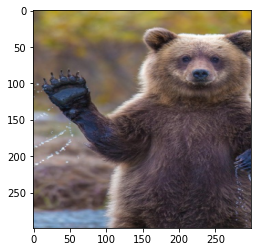

Жадное описание: A brown bear is swimming in the water.

Возможные описания из распределения:
1. A large brown bear is sitting in the river.
2. The large brown bear stands alone by the edge of the water
3. The large bear is looking to his right at a river


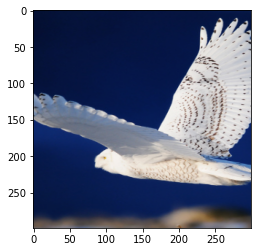

Жадное описание: A person on skis in the air with a snow covered mountain in the background.

Возможные описания из распределения:
1. A snow board that is upside down
2. A snow skier jumping off a ramp
3. An overhead shot of an open snow covered air capped snow capped hill.


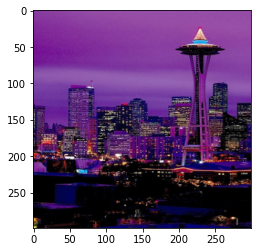

Жадное описание: A city skyline with a large building in the background.

Возможные описания из распределения:
1. A very high speed boat going over a busy street at sunset
2. A harbor filled with a clock and buildings.
3. A big city with some tall buildings


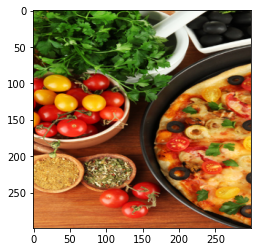

Жадное описание: A table with a pizza, tomatoes, and other vegetables.

Возможные описания из распределения:
1. Two small pizza slices on the cutting board and a bunch of greens.
2. Several dishes are sitting on a wooden cutting board with fruits.
3. Two wooden trays filled with different foods


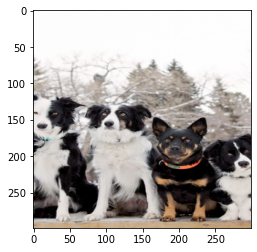

Жадное описание: A group of dogs sitting in the snow.

Возможные описания из распределения:
1. Six little dogs in their owner in a snowy field
2. There are five black dogs standing on top of a snowy day.
3. The black dog is carrying four dogs.


In [45]:
examples = [
    'https://www.anypics.ru/download.php?file=201602/320x480/anypics.ru-93418.jpg',
    'https://www.anypics.ru/download.php?file=201211/320x480/anypics.ru-33102.jpg',
    'https://www.anypics.ru/download.php?file=201211/320x480/anypics.ru-27822.jpg',
    'https://www.anypics.ru/download.php?file=201511/320x480/anypics.ru-90361.jpg',
    'https://www.anypics.ru/download.php?file=201602/320x480/anypics.ru-93223.jpg'        
]
for example in examples:
    show_image_by_url(example)

Посчитаем метрику BLEU для тестовой выборки

In [46]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

С помощью функции TRG.set_epoch() мы можем выбирать порядковый номер самописного описания. Таким образом сформируем два массива:
1. Сгенерированный на нулевой эпохе вектор предсказаний (эмбеддинг картинки -> строка описания)
2. На каждой из 5-и эпох заберём человекописные описания в качестве референса

In [48]:
hypotheses = []
references = []

network.eval()
TRG.set_const_mode()

def ids2word_list(ids):
    words = []
    for i in ids:
        word = TRG.vocab.itos[i]
        if word == '<sos>' or word == '<pad>': continue
        if word == '<eos>': break
        words.append(word)
    return words

for i in range(5):
    TRG.set_epoch(i)
    trg_point = 0
    for i_b, batch in enumerate(test_iterator):

        trg = batch.trg
        trg = trg.cpu().detach().tolist()
        trg = list(map(ids2word_list, trg))
        for t in range(len(trg)):
            if i == 0:
                references.append([trg[t]])
            else:
                references[trg_point].append(trg[t])
            trg_point += 1

        if i == 0:
            src = batch.src
            with torch.no_grad():
                memory = network.encode(src.to(device), None)

                word = TRG.vocab.stoi['<sos>']
                caption_prefix = torch.LongTensor([[word]] * src.shape[0])
                for _ in range(100):
                    with torch.no_grad():
                        output = network.decode(memory, caption_prefix.to(device),
                            src_mask=None, tgt_mask=subsequent_mask(caption_prefix.shape[1]).to(device))
                        output = network.generator(output[:, -1]).detach().cpu()
                        word = output.argmax(dim=1).unsqueeze(1).detach().cpu()
                    caption_prefix = torch.cat([caption_prefix, word], dim=1)
                
                output = list(map(ids2word_list, caption_prefix.tolist()))
                hypotheses = hypotheses + output

Проверим

In [49]:
def check_sent_i(idx):
    print('Предсказание:')
    print(hypotheses[idx])
    print()
    print('Исходные варианты:')
    for i, v in enumerate(references[idx]):
        print(f'{i+1}.', v)
        
check_sent_i(15)

Предсказание:
['a', 'man', 'throwing', 'a', 'frisbee', 'in', 'a', 'field', '.']

Исходные варианты:
1. ['a', 'husky', 'dog', 'is', 'carrying', 'a', 'frisbee', 'in', 'a', 'park', '.']
2. ['the', 'dog', 'is', 'ready', 'to', 'play', 'frisbee', 'in', 'the', 'fall', 'leaves', '.']
3. ['a', 'dog', 'standing', 'outside', 'with', 'a', 'frisbee', 'in', 'its', 'mouth', '.']
4. ['a', 'dog', 'in', 'a', 'park', 'with', 'a', 'frisbee', 'in', 'its', 'mouth', '.']
5. ['a', 'dog', 'in', 'a', 'field', 'with', 'a', 'frisbee', 'in', 'its', 'mouth']


Посчитаем BLEU

In [50]:
bleu = corpus_bleu(references, hypotheses)
print(f'BLEU = {bleu}')

BLEU = 0.2942692054407576


## Выводы

Я имплементировал трансформер из оригинальной статьи <a href="https://arxiv.org/pdf/1706.03762.pdf">Attention is all you need</a>, используя её "<a href="http://jalammar.github.io/illustrated-transformer/">разжёванную версию</a>", с оригинальными энкодером и декодером, а также Positional Encoding. Механика обучения также была заимствована, а именно LabelSmoothing и рекомендованный планировщик.

Метод кодирования картинки в "слова" был заимствован из <a href="https://arxiv.org/pdf/2010.11929.pdf">статьи про классификацию картинок</a>, было рассмотрено 3 варианта:

1. (Из статьи) Разбиение картинки на патчи и развертывание их в эмбеддинг слова. Этот метод требует предобучения трансформера на большом количестве данных, и я от него отказался.
2. (Моя идея) Использование CNN для получения многослойной картинки с низким разрешением, а затем группировка каналов в слова (ImageEmbeddings2dChannels). Эта идея не сработала: сеть начала генерировать связные, но рандомные описания, никак не согласующиеся с контентом картинки. Получилось, что эмбеддинг картинки воспринимался, как случайный вектор.
3. (Из статьи) Использование CNN для получения многослойной картинки с низким разрешением, а затем группировка многоканальных пикселей в слова (ImageEmbeddings2dPixels). Это разумно, так как трансформер "собирал" из пиксельных векторов общее представление картинки. При этом каждый пиксель/вектор был равнозначным, а каждый элемент в векторе значимым. Эта идея сработала.

Вместо 2-мерного Positional Encoding был выбран стандартный одномерный, так как картинки с низким разрешением имеют одинаковые размеры (8х8). Про это же говорорилось в статье про классификацию, что можно так.

Field, как источник данных для torchtext был модифицирован для наших нужд:

1. ImageField. Этот наследник умеет принимать пути картинок в качестве исходных данных, а на выходе отдавать загруженный тензор необходимых для CNN размеров с возможностью аугментации.
2. RandomField. Этот наследник умеет принимать несколько описаний и выдавать их либо в случайном порядке (используется для обучения), либо последовательно, выбирая по номеру (используется для теста) или осуществляя полный "обход" (используется для подсчёта bleu)

Благодаря этим наследникам, я смог использовать все "плюшки" torchtext в неизменном режиме, включая батчевалку, итераторы, деление на поддатасеты и др. Кроме того, я использовал предобученные вектора из FastText.

Я обучал трансформер 30 эпох примерно 8 часов. Потом "разморозил" веса CNN и обучал ещё 30 эпох. Благодаря аугментациям и нескольким описаниям для каждой картинки, а также большому значению dropout, переобучения не было. Можно было продолжать ещё.

CNN была использована с замороженными и размороженными весами. Для работы CNN мне пришлось скачать оригинальный датасет (тот же, чьи эмбеддинги были взяты для части с rnn) и использовать картинки, а не готовые эмбеддинги.

Метрика BLEU была посчитана по тестовой выборке и составила >0.29, это больше, чем у версии с rnn и меньшего количества параметров, что очень неплохо для моего количества ресурсов и "сложности" трансформера. Предложения строятся грамматически, лексически и семантически правильно, почти безупречно (в отличии от rnn).

В общем, можно констатировать, что трансформер у меня заработал лучше, чем версия с rnn (при этом использовался один и тот же cnn бэкэнд).